In [1]:
import os
from pathlib import Path
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [2]:
#print current working directory
print(os.getcwd())
repo_path = os.getcwd()

d:\VS_Projects\MIRA_MISA_LABS\MISA_LAB3


## Tissue models: segmentation using just intensity information

#### Pipeline: read images, preprocessing, check max intensity, lookup table (match intensity with tissue), based on the condirion extend the lookup table, obtain segmentation for test images. 

In [3]:
# load the tissue models
tm = pd.read_pickle(str(repo_path) + f'/data/our_tissue_models/tissue_model.p')

In [11]:
tm[1950]

array([0. , 0.5, 0.5])

# Read new test images to perform the segmentation

In [4]:
# Read patients in the test-set:
test_set_path = 'data/testing-set'
aux_patients_list = os.listdir(test_set_path + '/testing-images')
list_patient = []
for str1 in aux_patients_list:
    list_patient.append(str1.replace(".nii.gz", ""))

In [5]:
## Preprocessing -- skull removal step
def skull_removal(img, mask):
    brain_mask = mask>=1
    skull_strip = img*(brain_mask)
    return skull_strip

In [6]:
# save the array as a new nifti image
def save_as_nifti(array, filename, reference_image):
    """Save array as nifti image

    Args:
        array (array): array to be saved
        filename (str): path to save
        reference_image (str): path of reference image
    """
    reference_image = sitk.ReadImage(reference_image)
    image = sitk.GetImageFromArray(array)
    image.SetOrigin(reference_image.GetOrigin())
    image.SetSpacing(reference_image.GetSpacing())
    image.SetDirection(reference_image.GetDirection())
    sitk.WriteImage(image, filename)

In [25]:
def get_tissue_model_seg(list_patient, tm):
    arr_seg_imgs =[]
    # read images for each patient one by one
    for p in tqdm(list_patient):
        im_path = str(repo_path) + f'/data/testing-set/testing-images/{p}.nii.gz'
        mask_path = str(repo_path) + f'/data/testing-set/testing-labels/{p}_3C.nii.gz'
        img_array1 = sitk.GetArrayFromImage(sitk.ReadImage(str(im_path)))
        label_array1 = sitk.GetArrayFromImage(sitk.ReadImage(str(mask_path)))

        # Preprocessing - skull stripping
        img_array = skull_removal(img_array1, label_array1)

        # check the image maximum intensity
        max_value = int(np.max(img_array))
        max_value = max_value+1

        # get the maximum among the tissue
        lookup_table = np.argmax(tm, axis=1)+1 # the matching with intensity and tissue

        if max_value > len(lookup_table):
            # extend the lookup table accordingly.
            zeros = np.zeros(max_value-len(lookup_table)+1)
            lookup_table = np.append(lookup_table, np.array(zeros) ) # the filling for the exceptional intensities.

        array_int = np.array(img_array, dtype="uint16")
        new_img = lookup_table[array_int] #matching with the lookup table vs test images

        ## Apply skull stripping because increasing it by 1, increased the background intensity
        new_img = new_img*(label_array1>=1)

        # save the segmented image as a nifti image
        save_as_nifti(new_img.astype(np.float64), str(repo_path) + f'/data/TM_segmentation/tm_seg_{p}.nii', im_path)

        arr_seg_imgs.append(new_img)

    return arr_seg_imgs

In [26]:
arr_seg_imgs = get_tissue_model_seg(list_patient, tm)

100%|██████████| 20/20 [01:33<00:00,  4.69s/it]


In [20]:
def show_segmented_img(img_list):
    for im in img_list:
        plt.imshow(im[150], cmap = "gray")

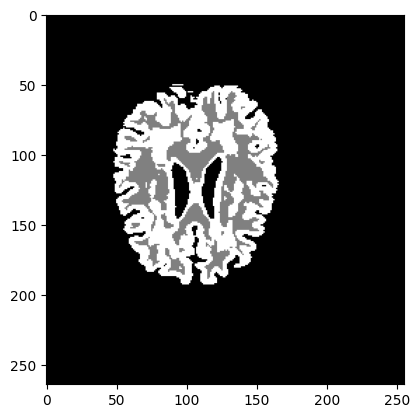

In [22]:
show_segmented_img(arr_seg_imgs)

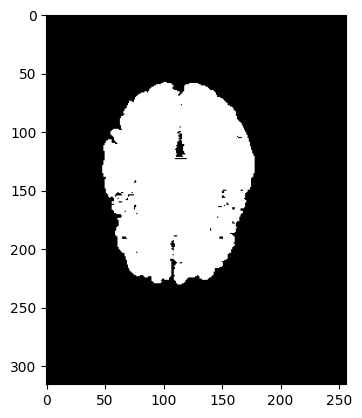

In [36]:
label_array1 = str(repo_path) + f'/data/testing-set/testing-labels/{list_patient[0]}_3C.nii.gz'
label_array2 = sitk.GetArrayFromImage(sitk.ReadImage(str(label_array1)))
image_1 = arr_seg_imgs[0]

plt.imshow(image_1[150], cmap = "gray")

In [38]:
def dice_score(image1, image2):
    image1 = sitk.GetArrayFromImage(image1)
    image2 = sitk.GetArrayFromImage(image2)
    image1[image1 > 0] = 1
    image2[image2 > 0] = 1
    intersection = np.sum(np.multiply(image1, image2))
    dice = 2 * intersection / (np.sum(image1) + np.sum(image2))
    return dice

# Calculate dice score for each patient and save as csv file
def get_dice_score(list_patient):
    ds_csf = []
    ds_gm = []
    ds_wm = []

    for i in range(len(list_patient)):
        seg_path = str(repo_path) + f'/data/TM_segmentation/tm_seg_{list_patient[i]}.nii'
        label_path = str(repo_path) + f'/data/testing-set/testing-labels/{list_patient[i]}_3C.nii.gz'
        seg_image = sitk.ReadImage(seg_path)
        label_image = sitk.ReadImage(label_path)
        for i in range(1, 4):
            d = dice_score(seg_image == i, label_image == i)
            if i == 1:
                ds_csf.append(d)
            elif i == 2:
                ds_gm.append(d)
            else:
                ds_wm.append(d)

    # save the dice scores as a csv file
    df = pd.DataFrame({'CSF': ds_csf, 'GM': ds_gm, 'WM': ds_wm})
    df.to_csv(str(repo_path) + f'/data/TM_segmentation/dice_scores.csv', index=False)

    return df

# seg_path = str(repo_path) + f'/data/TM_segmentation/tm_seg_1003.nii'
# label_path = str(repo_path) + f'/data/testing-set/testing-labels/1003_3C.nii.gz'
# seg_image = sitk.ReadImage(seg_path)
# seg_array = sitk.GetArrayFromImage(seg_image)
# label_image = sitk.ReadImage(label_path)

df = get_dice_score(list_patient)

In [39]:
# read the excel results
df = pd.read_csv(str(repo_path) + f'/data/TM_segmentation/dice_scores.csv')
df

,CSF,GM,WM
0,0.335081,0.811600,0.831584
1,0.632062,0.920615,0.946549
2,0.871246,0.919167,0.946341
3,0.487254,0.889889,0.913876
4,0.435575,0.918033,0.950524
5,0.420341,0.879629,0.904986
6,0.586196,0.901259,0.932314
7,0.853037,0.909262,0.944815
8,0.485183,0.911139,0.932820
9,0.374543,0.916818,0.942732
